# Get config for spherix

This notebook will allow visualization of the dataset and generate the config txt file to use with the spherix library.

HOW TO RUN:

1) Run the generate_dset.py script. Check the sumocfg scenario in the script to ensure the correct SUMO scenario is run. Ensure that the simulation is run long enough to collect enough number of trajectories.

2) Run the notebook trajectory_preprocessor.ipynb to extract training set. Choose the number of vehicle trajectories to extract (should be at least 200)!

3) Run this notebook. Ensure that the number of trajectories to sample (again) is reasonable (should be less than the number input in 2)).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

write_files = False # enable this flag to allow writing files

In [5]:
import pickle 

with open('trajectories.pyo', 'rb') as f: 
    edge_df = pickle.load(f)

In [9]:
x_traj = edge_df['x_vec']
y_traj = edge_df['y_vec']
t_vec = edge_df['t_vec']

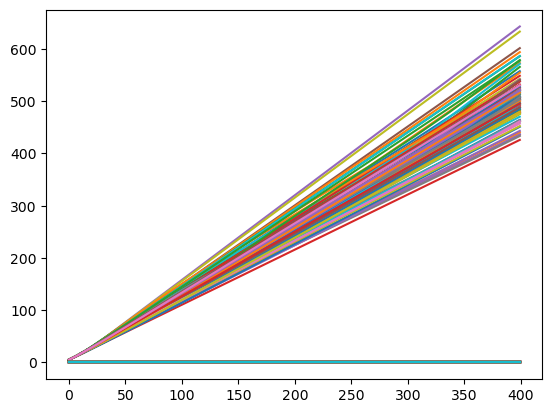

In [11]:
for i in range(x_traj.shape[0]):
    plt.plot(x_traj[i,:])

In [8]:
dfx = np.copy(x_traj)
dfy = np.copy(y_traj)

opt_traj_len = 320
dfx = np.zeros((100, opt_traj_len))
dfy = np.zeros((100, opt_traj_len))
dfx = dfx - np.tile(dfx[:,0], (opt_traj_len,1)).T
dfy = dfy - np.tile(dfy[:,0], (opt_traj_len,1)).T
j = 0
for i, id in enumerate(chosen_vehicle_ids):
    if j == 100:
        break
    if traj_lens[i] < opt_traj_len:
        print('Skip trajectory {:d}'.format(i))
        continue
    else:
        x_traj = edge_df[edge_df['vehicle_id'] == id]['x'].values
        y_traj = edge_df[edge_df['vehicle_id'] == id]['y'].values
        dfx[j, :opt_traj_len] = x_traj[:opt_traj_len]
        dfy[j, :opt_traj_len] = y_traj[:opt_traj_len]
        j += 1
print('Valid trajectories: {:d}'.format(j))

Skip trajectory 17
Skip trajectory 28
Skip trajectory 36
Skip trajectory 46
Skip trajectory 47
Skip trajectory 49
Skip trajectory 59
Skip trajectory 66
Skip trajectory 72
Skip trajectory 78
Skip trajectory 86
Skip trajectory 98
Skip trajectory 100
Skip trajectory 111
Valid trajectories: 100


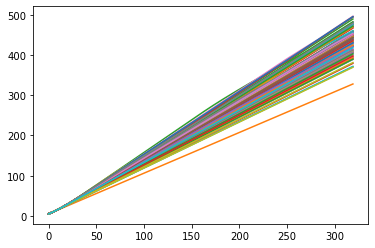

In [9]:
for i in range(100):
    plt.plot(dfx[i,:])

In [10]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA
fdx = skfda.FDataGrid(dfx, np.arange(dfx.shape[1]))
fpcax = FPCA(n_components=5)
fpcax.fit(fdx)

FPCA(n_components=5,
     weights=array([0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1....
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 

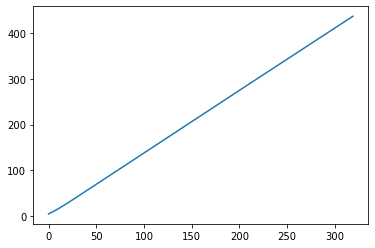

In [11]:
mean_x = fpcax.mean_.data_matrix.ravel()
plt.plot(mean_x)

The FPCA basis functions:

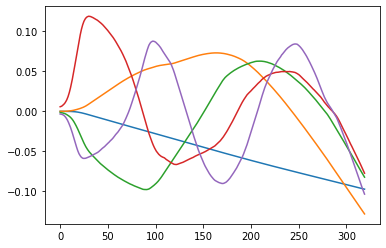

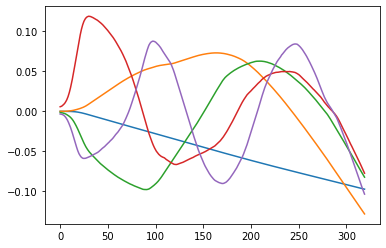

In [12]:
fpcax.components_.plot()

In [13]:
basis_x = fpcax.components_.data_matrix.reshape(fpcax.components_.data_matrix.shape[:2])

In [14]:
scores_x = fpcax.transform(fdx)

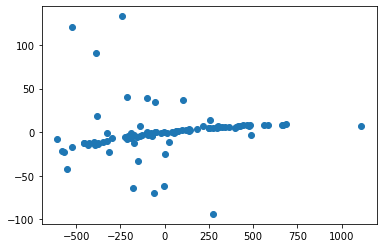

In [15]:
plt.scatter(scores_x[:,0], scores_x[:,1])

In [26]:
np.var(scores_x, axis=0)

array([1.12661890e+05, 7.74671807e+02, 6.50847844e+01, 9.61364771e+00,
       7.86367820e+00])

In [17]:
scores_x_var = np.var(scores_x, axis = 0)
scores_x_var

array([1.12661890e+05, 7.74671807e+02, 6.50847844e+01, 9.61364771e+00,
       7.86367820e+00])

Start writing to the config file

In [18]:
def vector_to_text(v):
    line_to_write = ''
    for m in v:
        line_to_write += (str(m) + ',')
    line_to_write = line_to_write[:len(line_to_write)-1]
    return line_to_write

In [19]:
if write_files:
    file1 = open("spherixcfg.txt", "w") 
    # first, write the mean_x
    file1.write(vector_to_text(mean_x) + '\n')
    # second, write the basis_x
    for i in range(basis_x.shape[0]):
        file1.write(vector_to_text(basis_x[i,:]) + '\n')
    # third, write the PCA scores covariance matrix
    pca_scores_cov_x = np.diag(scores_x_var)
    for i in range(basis_x.shape[0]):
        file1.write(vector_to_text(pca_scores_cov_x[i,:]) + '\n')
    # finally, write the measurement error
    file1.write(str(0.0001))
    file1.close() 

Get one trajectory

In [20]:
for x in dfx[69,:]:
    print(x, ', ', end="")

5.1 , 6.114497350611491 , 7.149410280448617 , 8.201576018874068 , 9.269142560701818 , 10.351681215179154 , 11.44822789016762 , 12.561736059916903 , 13.700430564951152 , 14.854366584486275 , 16.00171886087059 , 17.14831365262352 , 18.29621040111806 , 19.44308369274156 , 20.58953923224673 , 21.734963377180843 , 22.882430522812115 , 24.03898116773344 , 25.187168070068296 , 26.34201193877043 , 27.487257164961505 , 28.64262666105132 , 29.797889588991616 , 30.955735818015096 , 32.10898431288344 , 33.25939594585197 , 34.41062437622039 , 35.56135604441812 , 36.71068788153108 , 37.86246670379473 , 39.01116127264711 , 40.15849959457988 , 41.3103596103435 , 42.45874259109805 , 43.61105152832907 , 44.760547692141486 , 45.90568641495652 , 47.05091613930895 , 48.20416015869874 , 49.35042748698104 , 50.49989519718169 , 51.650092799977074 , 52.805765556295256 , 53.95396426423945 , 55.11115961299672 , 56.264946524689606 , 57.41701237227965 , 58.56962027600157 , 59.72488048242336 , 60.88201619510162 , 6

In [21]:
scores_x[69,:]

array([661.56671266,   7.87929401,   6.38649829,   0.67551856,
         4.06892955])

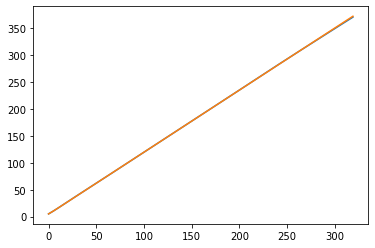

In [22]:
trj_apprx = basis_x.T @ scores_x[69,:].reshape((5,1)) + mean_x.reshape((320,1)) 
# trj_apprx = basis_x.T @ np.array([[331.92902863,   7.88604993,   1.69205272,   2.3331581 , 1.70704941]]).T + mean_x.reshape((320,1)) 
trj_true = dfx[69,:].reshape((320,1))

plt.plot(trj_apprx)
plt.plot(trj_true)

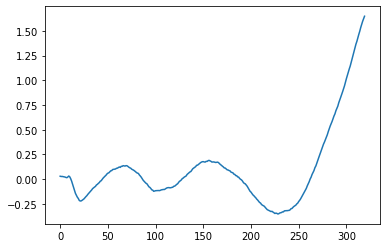

In [23]:
plt.plot(trj_true - trj_apprx)

In [24]:
# Also write the mean and basis functions out to a numpy-friendly way
import pickle 

if write_files:

    dump_obj = {"mean": mean_x, "basis": basis_x}
    with open('spherixcfg.pyo', 'wb') as f:
        pickle.dump(dump_obj, f)

    print('The mean and basis information have been written to the file spherixcfg.pyo')

In [25]:
if not write_files:
    print('Caution! No files were written due to the write_files flag')

Caution! No files were written due to the write_files flag
